# SynthDet Evaluation

This notebook is for the model prediction visualization. You can load your model and visualize predicted bounding boxes for the GroceriesReal validation dataset. This notebook would show you the performance metrics (mAP, mAP@IOU50, mAR@100) for your model based on GroceriesReal test dataset. Also, this notebook can analyze the easy and hard cases from the point of view of the model. This would provide a better understanding about how to minimize sim2real gaps or improve model performance.<br>
You can use this notebook by the following steps:
- Specify the model path. Then, the notebook would load the checkpoints into a `FasterRCNN` estimator. The `FasterRCNN` can provide model predictions.
- Can either specify or randomly select some cases for the visualization.
- This notebook would analyze high precision, high recall, low precision, low recall cases for the loaded model.

In [1]:
import pathlib
import os
import warnings

from PIL import ImageColor
from tensorboardX import SummaryWriter
from torchvision import transforms
from yacs.config import CfgNode as CN
import numpy as np
import pandas as pd
import plotly.express as px
import torch

from datasetinsights.io.downloader.unity_simulation import Downloader, download_manifest
from datasetinsights.datasets import Dataset
from datasetinsights.estimators.base import create_estimator
from datasetinsights.estimators import FasterRCNN, convert_bboxes2canonical
from datasetinsights.evaluation_metrics.confusion_matrix import prediction_records, precision_recall
from datasetinsights.io import EstimatorCheckpoint, KubeflowPipelineWriter
from datasetinsights.stats import grid_plot, plot_bboxes, histogram_plot

warnings.filterwarnings('ignore')

## Settings
Specify your settings down below

In [2]:
# local data path to save downloaded dataset:
data_path = "/Users/bowen.li/data/groceries/v3"
# Top/Bottom K images to show according to precision/recall score
K = 3

Please choose one public model (and comment out other URLs)

In [3]:
# 1. Real-trained model on 760 images
# ESTIMATOR_URL = "https://storage.googleapis.com/datasetinsights/models/Real-World/FasterRCNN.estimator"

# 2. Synth-trained model on 400K SynthDet dataset
# ESTIMATOR_URL = "https://storage.googleapis.com/datasetinsights/models/Synthetic/FasterRCNN.estimator"

# 3. Fine-tuned model (pre-trained on 400K Synthetic data and fine-tuned on 76 images)
# ESTIMATOR_URL = "https://storage.googleapis.com/datasetinsights/models/Synthetic-And-Real-World-76-images/FasterRCNN.estimator"

# 4. Fine-tuned model (pre-trained on 400K Synthetic data and fine-tuned on 380 images)
# ESTIMATOR_URL = "https://storage.googleapis.com/datasetinsights/models/Synthetic-And-Real-World-380-images/FasterRCNN.estimator"

# 5. Fine-tuned model (pre-trained on 400K Synthetic data and fine-tuned on 760 images)
ESTIMATOR_URL = "https://storage.googleapis.com/datasetinsights/models/Synthetic-And-Real-World-760-images/FasterRCNN.estimator"

## Load data
Load GrocereisReal validation and test data. The validation dataset is used for model prediction visualization. The test dataset is used for testing model performance (mAP, mAP@IOU50, mAR).

In [4]:
# use python code to download the data.
!python -m datasetinsights.commands.download --source_uri=https://storage.googleapis.com/datasetinsights/data/groceries/v3.zip

In [5]:
val_dataset = Dataset.create(
    "GroceriesReal",
    data_path=data_path,
    split="val",
    transforms=FasterRCNN.get_transform()
)
print("Length of GroceriesReal validation data:", len(val_dataset))

Length of GroceriesReal validation data: 253


In [6]:
test_dataset = Dataset.create(
    "GroceriesReal",
    data_path=data_path,
    split="test",
    transforms=FasterRCNN.get_transform()
)
print("Length of GroceriesReal test data:", len(test_dataset))

Length of GroceriesReal test data: 254


In [7]:
if torch.cuda.is_available():
    print("Using cuda")
    device = torch.device("cuda")
else:
    print("Using cpu")
    device = torch.device("cpu")

Using cpu


## Load Model

In [ ]:
# TODO: make sure it's working
def load_estimator(checkpoint_file):
    
    config = CN.load_cfg(open("../datasetinsights/configs/faster_rcnn_groceries_real.yaml", "r"))
#     m_ap = CN()
#     m_ap.name = "MeanAveragePrecisionAverageOverIOU"
#     m_ap_50 = CN()
#     m_ap_50.name = "MeanAveragePrecisionIOU50"
#     m_ar = CN()
#     m_ar.name = "MeanAverageRecallAverageOverIOU"
#     metrics = CN()
#     metrics.mAP = m_ap
#     metrics.mAPIOU50 = m_ap_50
#     metrics.mAR = m_ar
#     dataset = CN()
#     dataset.name = "GroceriesReal"

#     config = CN()
#     config.pretrained = False
#     config.backbone = "resnet50"
#     config.num_classes = 64
#     config.checkpoint_file = checkpoint_file
#     config.estimator = "FasterRCNN"
#     config.pretrained_backbone = True
#     config.system = system
#     config.metrics = metrics
#     config.test = dataset

    writer = SummaryWriter()
    estimator = create_estimator(
        config=config,
        name=config.estimator,
        checkpoint_file=checkpoint_file,
        checkpoint_dir=writer.logdir,
    )

    return estimator

estimator = load_estimator(ESTIMATOR_URL)

## Model Prediction Visualization

Use the loaded model to predict on GroceriesReal Validation Dataset. We highlight predicted bounding boxes into 2 colors:
- <font color='green'>Green boxes</font>: it's a correct predicted label and overlap the true box enough (overlap >= 0.5). <br>
- <font color='red'>Red boxes</font>: it's a wrong prediction.<br>

In [11]:
label_mappings = pd.DataFrame(val_dataset.label_mappings.items(), columns=["Label ID", "Label Name"])

In [18]:
def prediction(estimator, dataset, index, iou_thresh=0.5, box_score_thresh=0.5):
    """ model prediction.

    Args:
        estimator (FasterRCNN): sim2real model.
        dataset: Dataset for prediction.
        iou_thresh (float): iou threshold. Defaults to 0.5.
        box_score_thresh (float): box score threshold for filter out lower score bounding boxes. Defaults to 0.5.
        index (int): image index used for prediction. Defaults to None.

    Returns:
        a list of annotations.
    """
    pil_img, annotation = dataset[index]
    annotation = convert_bboxes2canonical([annotation])[0]
    img = transforms.ToPILImage()(pil_img).convert("RGB")
    estimator.model.eval()
    predict_annotation = estimator.predict(pil_img, box_score_thresh=box_score_thresh)
    return img, annotation, predict_annotation

In [13]:
COLOR_MAPPING = ("red", "green")
def render_color_boxes(image, annotation, predict_annotation, font_size=100, box_line_width=15):
    """ render color for each box in one image.

    Args:
        image (PIL Image): the image for rendering.
        annotation (list[BBox2D]): ground truth annotation.
        predict_annotation (list[BBox2D]): predicted annotation.
        line_width (float): line width of the bounding boxes. Defaults to 10.
        font_scale (int): how many chars can be filled in the image horizontally. Defaults to 50.

    Returns:
        a rendered image.
    """
    pred_infos = prediction_records(annotation, predict_annotation)
    colors = [COLOR_MAPPING[rec] for score, rec in pred_infos]
    pred_img = plot_bboxes(
        image,
        predict_annotation,
        label_mappings,
        colors=colors,
        font_size=font_size,
        box_line_width=box_line_width,
    )
    return pred_img

In [14]:
def visualize_predictions(image_indicies):
    """ visualize predictions for SynthDet model (or real2real model).

    Args:
        image_indicies (list[int]): image indices for the visualization.

    """
    for i in image_indicies:
        img, annotation, synth_pred_ann = prediction(
            estimator,
            val_dataset,
            i,
            iou_thresh=0.5,
            box_score_thresh=0.5,
        )
        gt_img = plot_bboxes(img, annotation, label_mappings, font_size=100, box_line_width=15)
        synth_pred_img = render_color_boxes(img, annotation, synth_pred_ann, font_size=100, box_line_width=15)
        titles = [
            f"ground truth bounding boxes for Img {i + 1}",
            f"sim2real prediction for Img {i + 1}",
        ]
        grid_plot([[gt_img, synth_pred_img]], figsize=(7, 10), img_type="rgb", titles=titles)

### Predictions for some user-selected or randomly-selected cases

You can specify some cases or randomly select K cases. For each image, there are two plots:
- The left one is the ground truth image. <br>
- The right one is the model prediction.<br>

In [15]:
# specify image_indicies if you want to visualize a particular set of images
# image_indicies = [0, 1, 2]
image_indicies = np.random.randint(0, len(val_dataset) - 1, size=K)

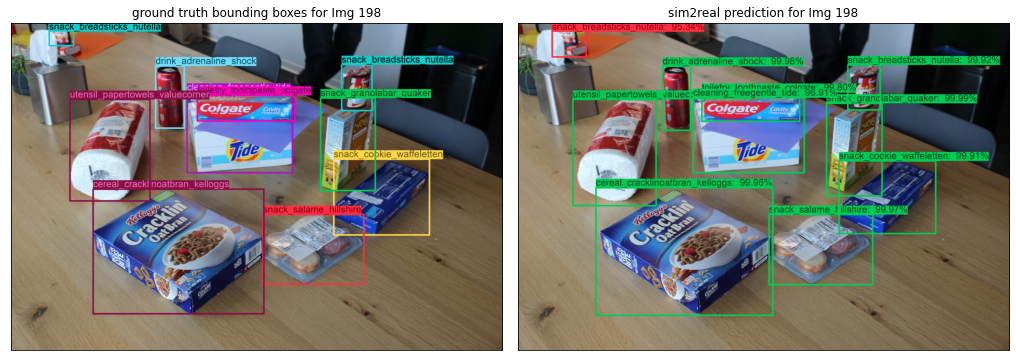

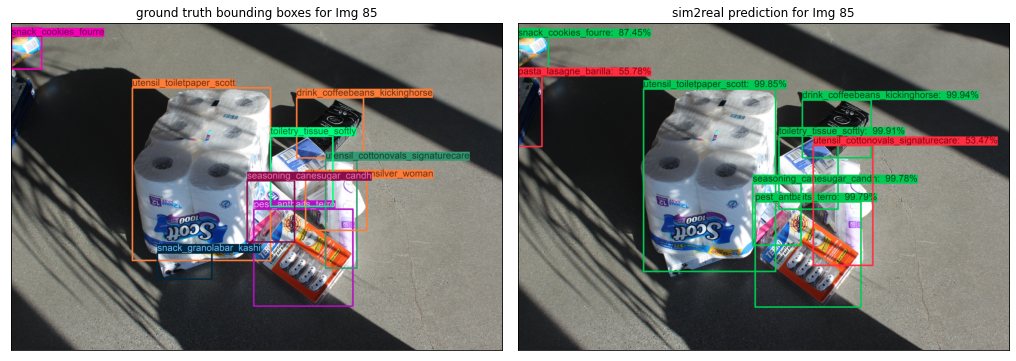

In [19]:
visualize_predictions(image_indicies)

## Model performance metrics
This section would show you the model performance on GroceriesReal test dataset. You would see:
- Average Precision@IOU=50 per class
- Three evaluation metrics: mAP, mAP@IOU50, mAR@100)

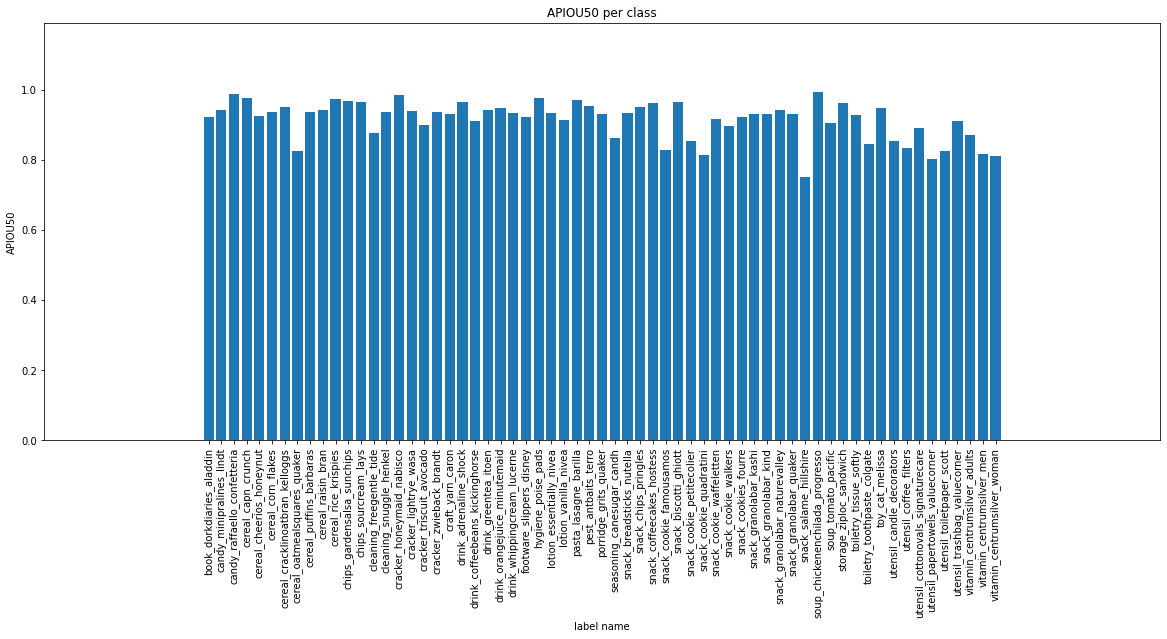

In [9]:
estimator.evaluate(data_path, test_data=test_dataset)

In [38]:
metrics_file = open("../metrics/20200818-234427")
metrics_file.readlines()

['{"metrics": [{"name": "mAP", "numberValue": 0.7032764212160857, "format": "RAW"}, {"name": "mAPIOU50", "numberValue": 0.9147737308671372, "format": "RAW"}, {"name": "mAR", "numberValue": 0.7522489586613507, "format": "RAW"}]}']

## Visualization by precision/recall (Optional)

This section would take lots of time (Normally 50 minutes) to run.
We use this section to:<br>
- identify/visualize sim2real gaps.
- analyze easy and hard cases from the point of view of the model.

In this section, We compute the prediction per image according to precision/recall. Here we define the precision/recall per image as follows:

-  precision per image = TP / (TP + FP).
-  recall per image = TP / (TP + FN). 

Here, True Positive (TP) are defined as the the bounding boxes with IOU > threshold. We choose threshold = 0.5.
This preidcition is class agnostic. It's computed per image.


###  Per image precision and recall distribution

In [20]:
def calculate_all_pr(
    model,
    dataset,
    rate_records,
    iou_thresh=0.5,
):
    
    """ calculate precision and recall for all images.
        
    Args:
        model (FasterRCNN): a faster_rcnn model.
        dataset: Dataset for prediction.
        iou_thresh (float): iou threshold. Defaults to 0.5.
        rate_records (pandas.DataFrame): prediction records. It has three columns, id, precision, recall

    """
    for i in range(len(dataset)):
        pil_img, annotation = dataset[i]
        annotation = convert_bboxes2canonical([annotation])[0]
        predict_annotation = model.predict(pil_img, box_score_thresh=0.5)
        ap, ar = precision_recall(annotation, predict_annotation, iou_thresh)
        rate_records.loc[len(rate_records)] = [i, ap, ar]

In [21]:
# calculate precison recall for all images and all prediction
rate_records = pd.DataFrame({
    "id": pd.Series([], dtype="int"),
    "precision": pd.Series([], dtype="float"),
    "recall": pd.Series([], dtype="float")
})
calculate_all_pr(estimator, val_dataset, rate_records, iou_thresh=0.5)
rate_records["id"] = rate_records["id"].astype(int)

In [36]:
histogram_plot(
    rate_records, 
    x="precision",  
    x_title="precision",
    y_title="Frequency",
    title="Precision per image distribution",
)

In [35]:
histogram_plot(
    rate_records, 
    x="recall",  
    x_title="Recall per image",
    y_title="Frequency",
    title="Recall per image distribution",
)

### The following section visualize four cases 

We pick K images from the following regions:

- [High Precision](#high_precision)
- [High Recall](#high_recall)
- [Low Precision](#low_precision)
- [Low Recall](#low_recall) 


<a id='high_precision'></a>
#### High Precision

In [24]:
precision_easy_cases = rate_records.nlargest(K, "precision")
precision_easy_cases

id  precision  recall
1   1        1.0     1.0
2   2        1.0     1.0
3   3        1.0     1.0

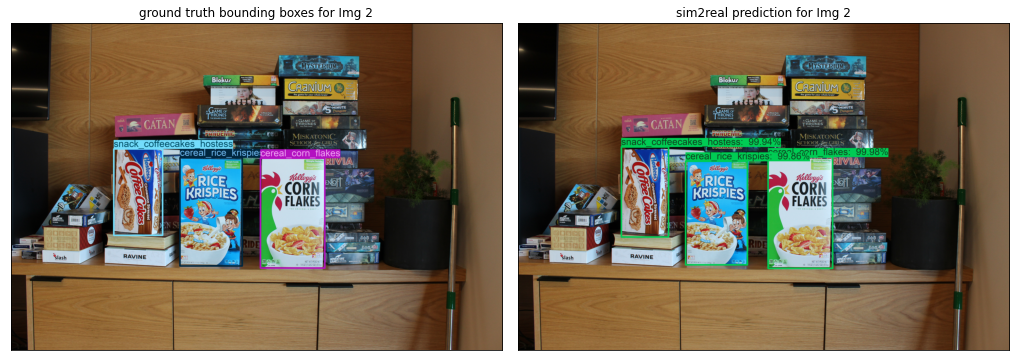

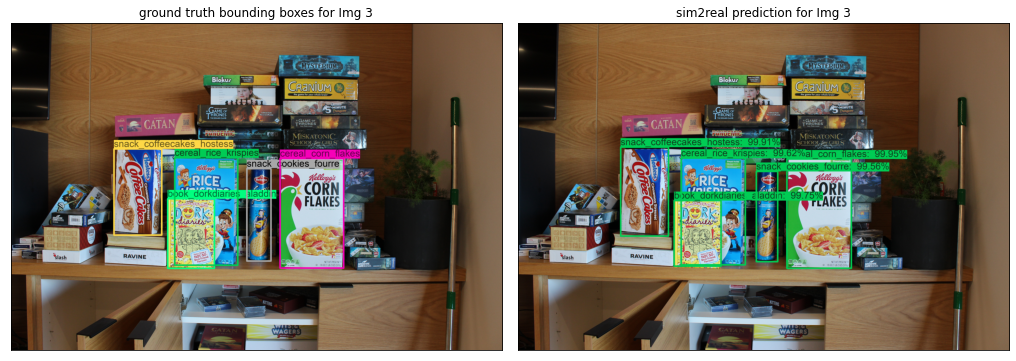

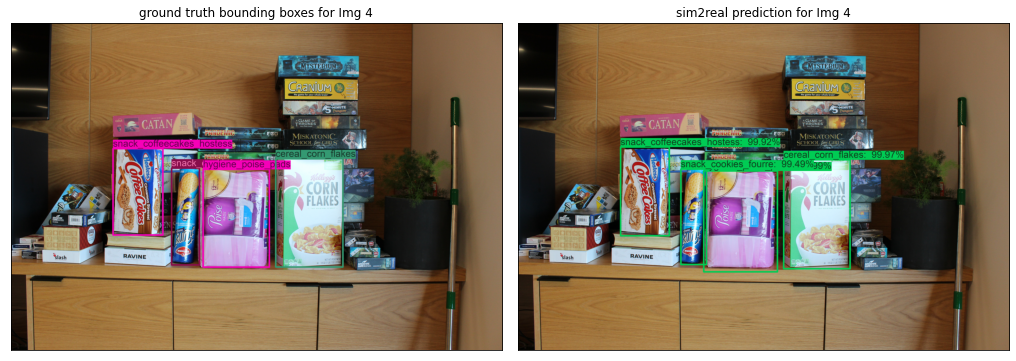

In [25]:
visualize_predictions(precision_easy_cases["id"])

<a id='high_recall'></a>
#### High Recall

In [26]:
recall_easy_cases = rate_records.nlargest(K, 'recall')
recall_easy_cases

id  precision  recall
0   0        0.5     1.0
1   1        1.0     1.0
2   2        1.0     1.0

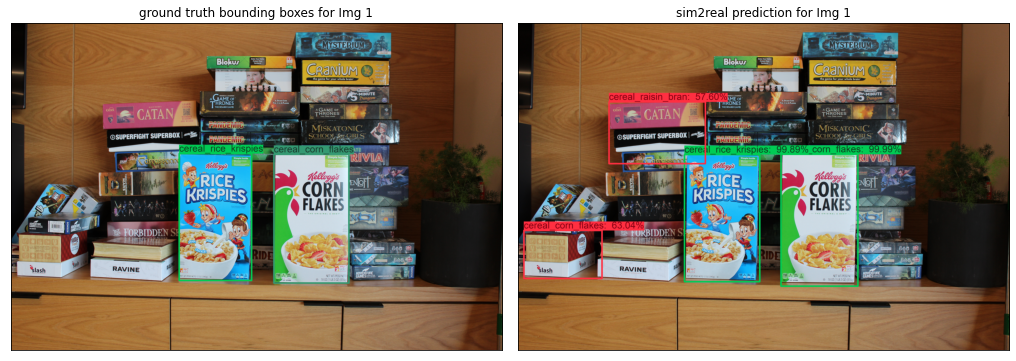

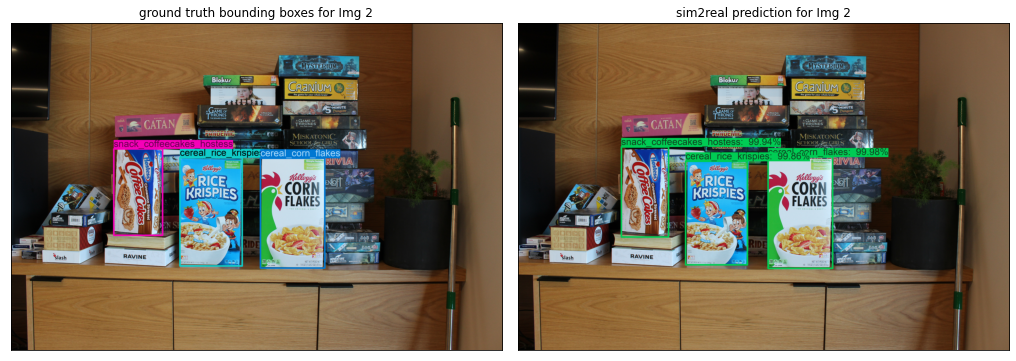

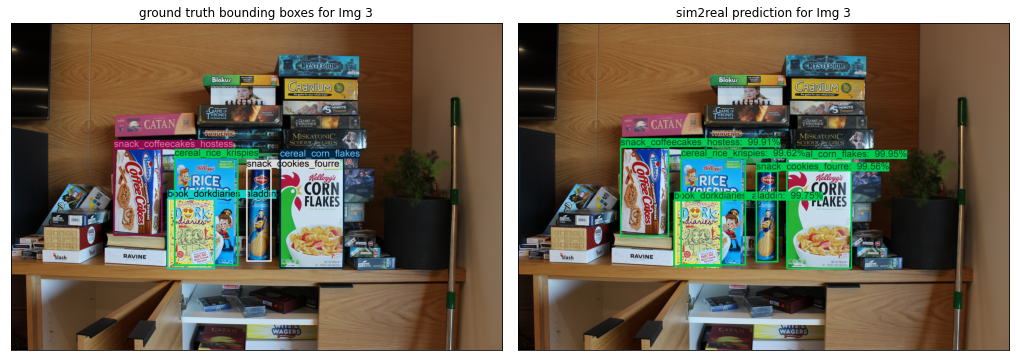

In [27]:
visualize_predictions(recall_easy_cases["id"])

<a id='low_precision'></a>
#### Low Precision

In [28]:
precision_hard_cases = rate_records.nsmallest(K, 'precision')
precision_hard_cases

id  precision    recall
130  130   0.333333  0.428571
92    92   0.400000  1.000000
217  217   0.416667  0.833333

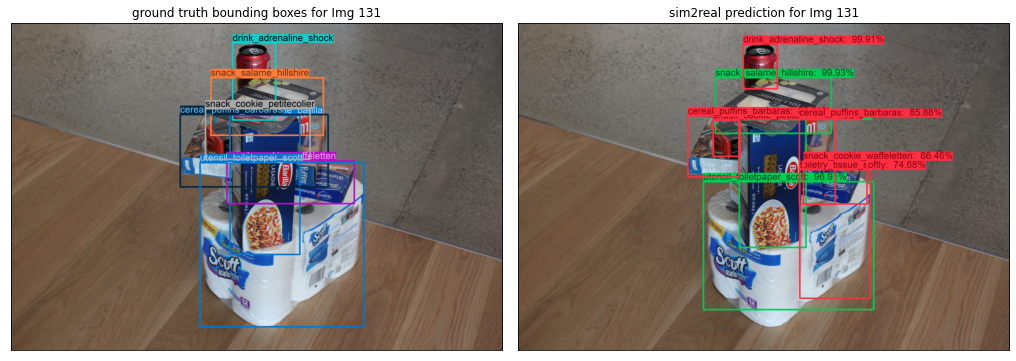

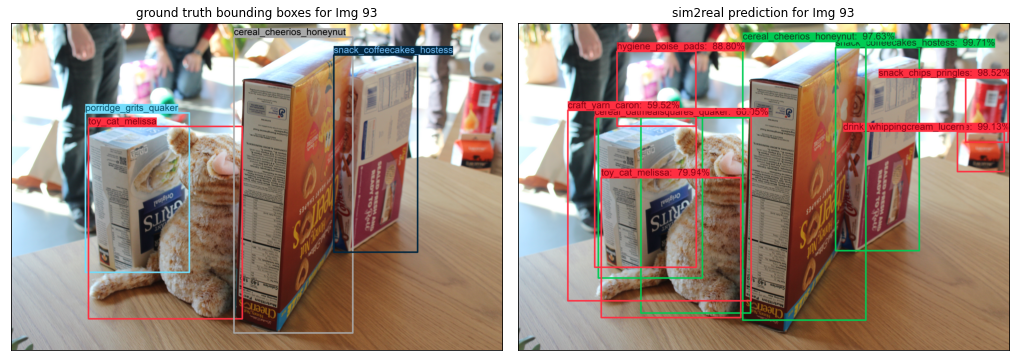

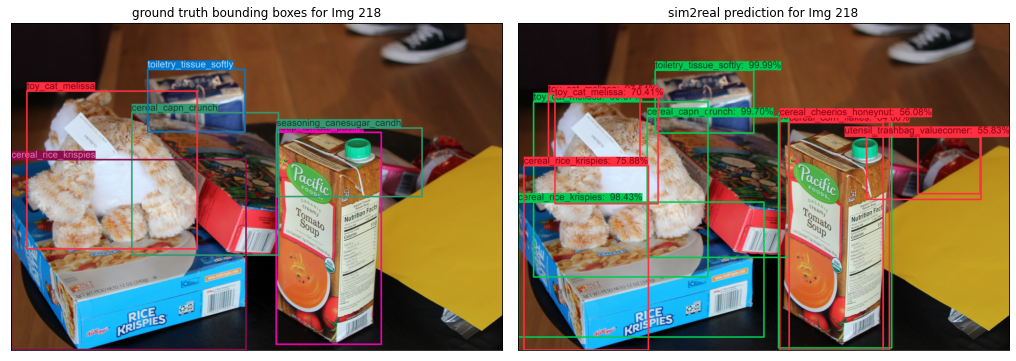

In [29]:
visualize_predictions(precision_hard_cases["id"])

<a id='low_recall'></a>
#### Low Recall

In [30]:
recall_hard_cases = rate_records.nsmallest(K, 'recall')
recall_hard_cases

id  precision    recall
68    68   0.466667  0.411765
130  130   0.333333  0.428571
155  155   1.000000  0.428571

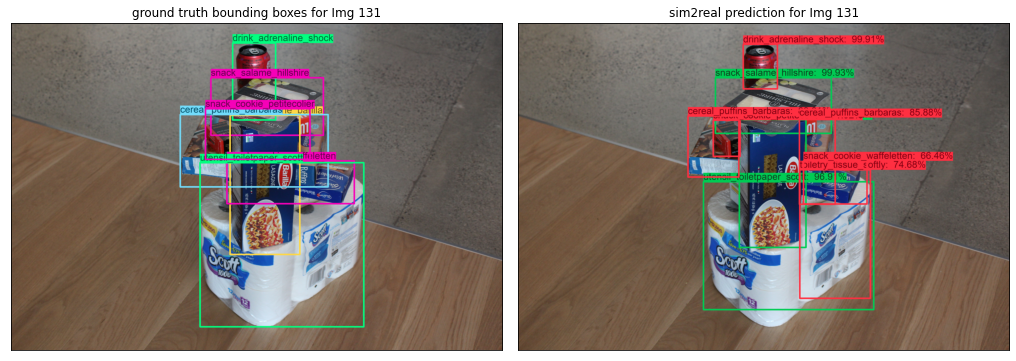

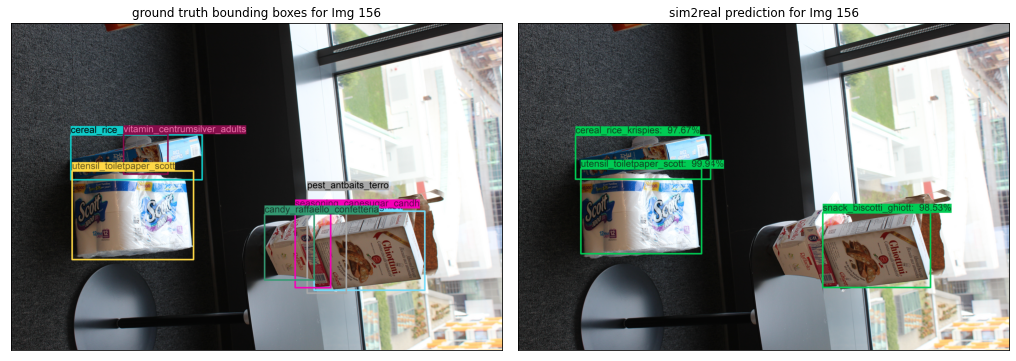

In [31]:
visualize_predictions(recall_hard_cases["id"])